In [1]:
import joblib
import os
import math
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome.connectivity_matrices import sym_matrix_to_vec
from neuroginius.plotting import plot_matrix
from neuroginius.atlas import Atlas

from cogpred.utils.configuration import get_config
from cogpred.transformers import MatrixMasker
from cogpred.loading import make_training_data
from cogpred.utils.naming import make_run_path

config = get_config()
conn_dir = config["connectivity_matrices"]

ATLAS = "msdl"
atlas = Atlas.from_name(ATLAS)
k = 3
REFNET = np.unique(atlas.macro_labels)
INTER = REFNET
#REFNET = ("Default",)
#INTER = ("Default",)

sns.reset_defaults()
# TODO Deconfounding in the pipeline?

In [2]:
matrices, metadata = make_training_data(conn_dir, ATLAS, k)
run_path = make_run_path(
    config["output_dir"],
    k=k,
    feat="fc",
    atlas=ATLAS,
    net="".join(REFNET),
    inter="".join(INTER)
)

if len(run_path.name) > 55:
    print("too long")
    run_path = make_run_path(
        config["output_dir"],
        k=k,
        feat="fc",
        atlas=ATLAS,
        net="all"
    )
    
os.makedirs(run_path, exist_ok=True)
metadata.to_csv(run_path / "metadata.csv")

Dropping 9 subjects because of lacking MMMSE
too long


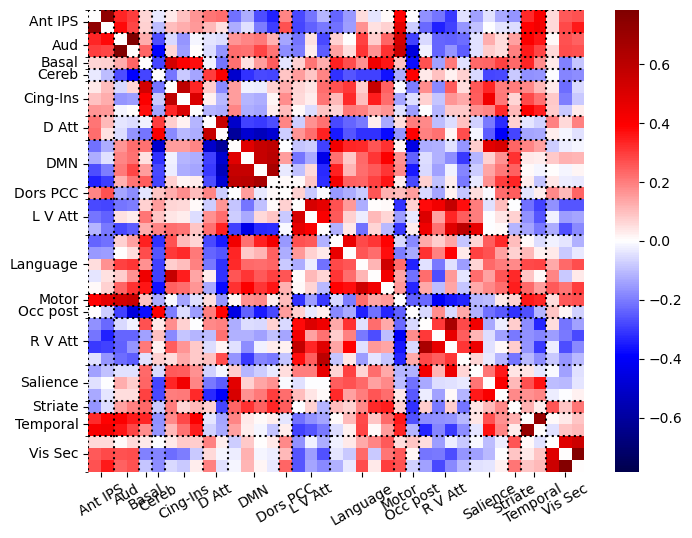

In [3]:
plot_matrix(matrices[1], atlas)
plt.show()

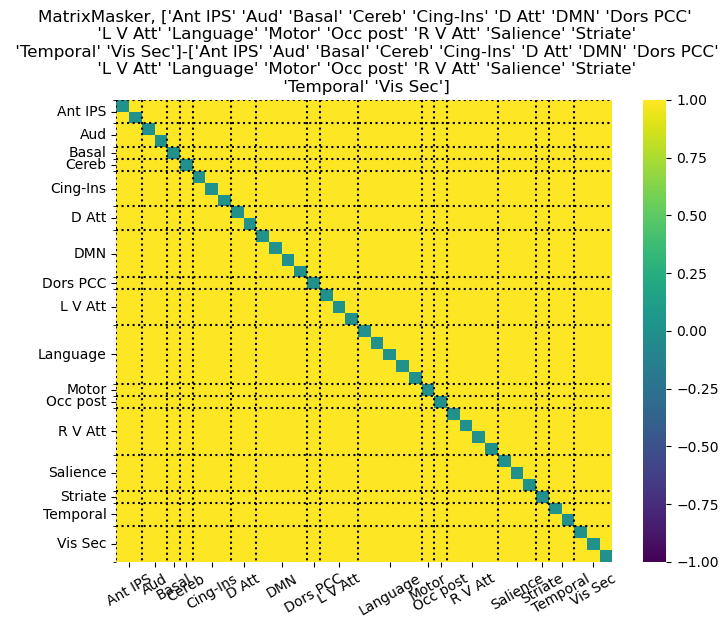

In [4]:
masker = MatrixMasker(REFNET, INTER, atlas=atlas).fit(matrices, metadata)

masker.fit(matrices).plot(cmap="viridis")
plt.show()

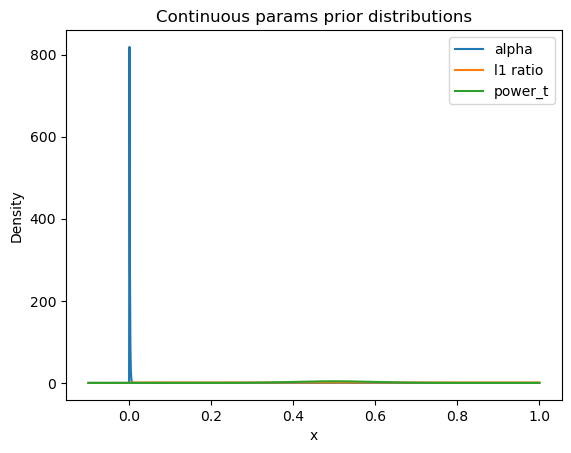

In [5]:
from scipy import stats

lambda_param = 1000
alpha_distribution = stats.expon(scale=1/lambda_param)
l1_ratio = stats.uniform(0, 1)
power_t = stats.norm(loc=0.5, scale=0.1)

x = np.linspace(-0.1, 1, 1000)
da = alpha_distribution.pdf(x)
dl = l1_ratio.pdf(x)
dt = power_t.pdf(x)


plt.plot(x, da, label="alpha")
plt.plot(x, dl, label="l1 ratio")
plt.plot(x, dt, label="power_t")
plt.title("Continuous params prior distributions")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()


In [6]:
param_dist = {
    "classifier__loss": ["hinge", "log_loss", "modified_huber"],
    "classifier__alpha": alpha_distribution,
    "classifier__l1_ratio": l1_ratio,
    "classifier__power_t": power_t,
}

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn import preprocessing

from sklearn.decomposition import PCA
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import f1_score
from functools import partial

from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedGroupKFold, StratifiedKFold
from cogpred.supervised import macro_f1
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors

sgd = SGDClassifier(
    penalty="elasticnet",
    class_weight="balanced", 
    random_state=1999
)


clf = Pipeline(
    [
    ("matrixmasker", MatrixMasker(REFNET, INTER, atlas=atlas)),
    ("scaler", preprocessing.StandardScaler()),
    #("smote", SMOTE(
    #    random_state=1234,
    #    sampling_strategy="minority",
    #    k_neighbors=NearestNeighbors(n_neighbors=2, n_jobs=-1)
    #)),
    ("classifier", sgd)
    ],
    verbose=False
)

inner_cv = StratifiedGroupKFold(n_splits=8, shuffle=True, random_state=1999)
outer_cv = StratifiedGroupKFold(n_splits=8, shuffle=True, random_state=1999)

search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=100,
    scoring=macro_f1,
    cv=inner_cv,
    random_state=1999,
    verbose=1,
    n_jobs=8,
    error_score="raise"
)

In [8]:
y = metadata.cluster_label.values
search.fit(matrices, y, groups=metadata.CEN_ANOM.values)
cv_results = pd.DataFrame(search.cv_results_).sort_values(by="mean_test_score", ascending=False)
cv_results

Fitting 8 folds for each of 100 candidates, totalling 800 fits


/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Co

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__l1_ratio,param_classifier__loss,param_classifier__power_t,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
29,0.590316,0.114255,0.008626,0.003105,0.000168,0.634465,log_loss,0.587124,"{'classifier__alpha': 0.00016833862856053424, ...",0.374214,0.404558,0.426847,0.341246,0.370837,0.366701,0.367673,0.407061,0.382392,0.026058,1
30,0.447644,0.107057,0.008198,0.002590,0.000125,0.633808,modified_huber,0.586524,"{'classifier__alpha': 0.00012450311948836726, ...",0.339955,0.384795,0.427855,0.376986,0.363158,0.346491,0.400293,0.415836,0.381921,0.029578,2
51,0.487121,0.111832,0.008077,0.002889,0.000200,0.512215,hinge,0.424785,"{'classifier__alpha': 0.00019980213894415648, ...",0.374193,0.411518,0.386226,0.348110,0.383442,0.379825,0.403569,0.360652,0.380942,0.019421,3
12,0.482837,0.117762,0.008554,0.003005,0.000072,0.767083,hinge,0.461572,"{'classifier__alpha': 7.181237636869161e-05, '...",0.351069,0.387542,0.424346,0.373009,0.383307,0.329485,0.394910,0.399475,0.380393,0.027551,4
11,0.506116,0.124769,0.008384,0.002671,0.000396,0.805349,modified_huber,0.536124,"{'classifier__alpha': 0.0003960917242958784, '...",0.341128,0.385185,0.420320,0.384349,0.375586,0.309319,0.388889,0.422018,0.378349,0.035392,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0.517766,0.119395,0.008179,0.002761,0.000606,0.617619,hinge,0.443736,"{'classifier__alpha': 0.0006061494313201925, '...",0.327364,0.409747,0.395795,0.326708,0.321761,0.317101,0.387658,0.333496,0.352454,0.035784,96
14,0.560535,0.111239,0.008813,0.003934,0.000018,0.312170,modified_huber,0.436028,"{'classifier__alpha': 1.8236463843582345e-05, ...",0.318699,0.380526,0.355158,0.310204,0.371675,0.334634,0.404067,0.344264,0.352403,0.029870,97
45,1.044068,0.279327,0.008667,0.002912,0.000702,0.963131,hinge,0.383569,"{'classifier__alpha': 0.0007023507324455655, '...",0.315106,0.361420,0.415432,0.326589,0.335006,0.354816,0.349387,0.358502,0.352032,0.028428,98
78,1.174995,0.429698,0.008257,0.002358,0.001798,0.890041,hinge,0.625186,"{'classifier__alpha': 0.0017975202621170992, '...",0.309771,0.379277,0.320110,0.365691,0.347485,0.332139,0.360112,0.374590,0.348647,0.024064,99


In [9]:
est = search.best_estimator_
reg = est.named_steps["classifier"]
masker = est.named_steps["matrixmasker"]
atlas = masker.atlas

In [10]:
def net_select(label):
    if label in masker.refnet or label in masker.interaction:
        return 1
    return 0

regions = []
for region, network in zip(atlas.labels, atlas.macro_labels):
    if network in masker.refnet or network in masker.interaction:
        regions.append(region)

# Hack to remove that annoying dtype thing from nilearn
regions = list(np.array(regions).astype(str))

n_regions = sum(map(net_select, atlas.macro_labels))

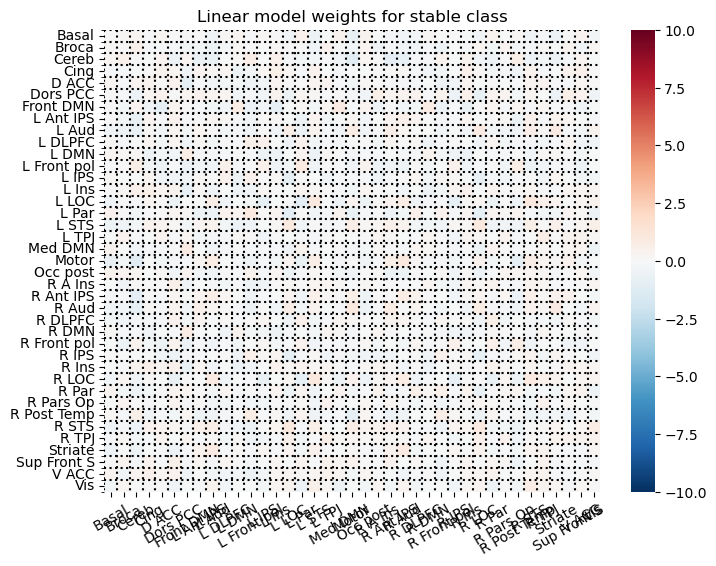

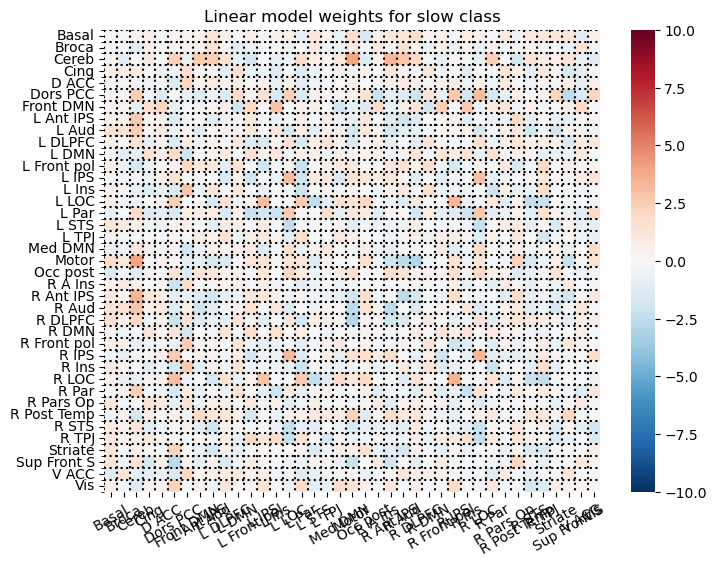

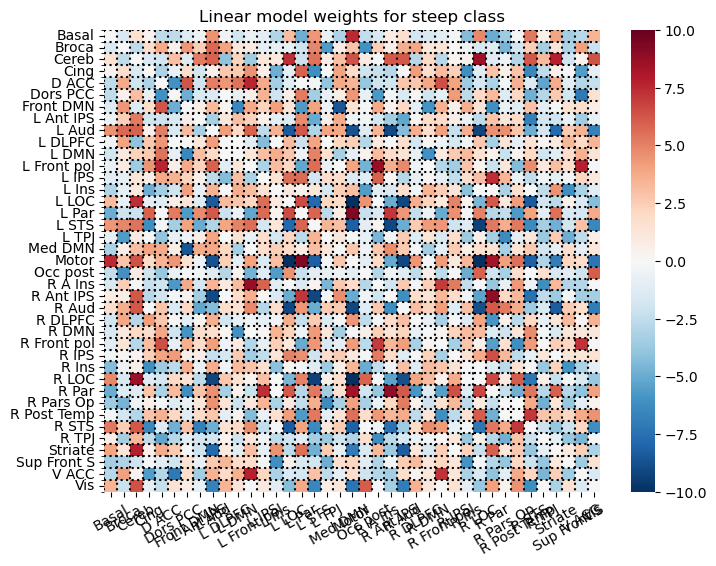

In [11]:
from nilearn.connectome import vec_to_sym_matrix

def region_split(label):
    return label.split("_")[-2]

class MockAtlas:
    if atlas.name == "schaefer200":
        macro_labels = list(map(region_split, regions))
    else:
        macro_labels = regions
    
cats = ("stable", "slow", "steep")
for i in range(k):

    coefs = reg.coef_[i, :]

    # Perform Hauf transform to make coefs interpretable
    X = masker.transform(matrices)
    patterns = np.cov(X.T) @ coefs

    arr = vec_to_sym_matrix(patterns, diagonal=np.zeros(n_regions))
    cat = cats[i]
    axes = plot_matrix(
        np.where(np.abs(arr) > 0, arr, 0),
        MockAtlas(),
        cmap="RdBu_r",
        bounds=(-10, 10)
    )
    axes.set_title(f"Linear model weights for {cat} class")
    plt.show()

In [12]:
test_scores = cross_val_score(
    search,
    matrices,
    y,
    cv=outer_cv.split(matrices, y, groups=metadata.CEN_ANOM.values),
    n_jobs=8,
    scoring=macro_f1,
    verbose=1,
    params={"groups": metadata.CEN_ANOM.values} # This is for inner cv
)
test_scores

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits


/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Co

array([0.31869919, 0.37785658, 0.41216931, 0.32903307, 0.33500647,
       0.32748333, 0.4032049 , 0.34426414])

In [13]:
import joblib
cv_results.to_csv(run_path / "cv_results.csv")
#joblib.dump(test_scores, run_path / "test_scores.joblib")
joblib.dump(search.best_estimator_, run_path / "best_estimator.joblib")

['/homes_unix/jlegrand/data/Memento/output/prediction/k-3_feat-fc_atlas-msdl_net-all/best_estimator.joblib']